# 🔁 Réseau de neurones récurrent LSTM bi-directionnel 🔁

Dans ce notebook, nous testons un **réseau de neurones récurrent LSTM bi-directionnel** pour la classification en utilisant la bibliothèque **Keras**. Les prétraitements sont les mêmes que ceux effectués avec CNN, comme le sont aussi les plongements utilisés.

Nous avons opté pour une **méthodologie** très proche à celle utilisée avec CNN **(entraînement sur les descriptions sans mots outils, nombre d'époques, plongement modifiés pendant l'apprentissage)** pour obtenir des résultats comparables.

Nous répétons les mêmes tests sur les trois colonnes de notre jeu de données test.

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

## Chargement des données

In [2]:
# Création du dossier data
!mkdir data
# Téléchargement des fichiers train et test dans le dossier data
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv

--2024-12-10 15:32:06--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289798 (283K) [text/plain]
Saving to: ‘data/test.csv’

test.csv            100%[===================>] 283.01K  --.-KB/s    in 0.03s   

2024-12-10 15:32:06 (10.2 MB/s) - ‘data/test.csv’ saved [289798/289798]

--2024-12-10 15:32:06--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

In [3]:
dtypes = dtype= {'label_fr': 'category',
                 'description': 'object',
                 'description_tokens': 'object',
                 'description_wosw': 'object',
                 'description_lemmas': 'object',
                 'simple': 'object',
                 'simple_tokens': 'object',
                 'simple_wosw': 'object',
                 'simple_lemmas': 'object',
                 'fautes': 'object',
                 'fautes_tokens': 'object',
                 'fautes_wosw': 'object',
                 'fautes_lemmas': 'object'}

In [4]:
train_df = pd.read_csv("data/train.csv", sep = ",", index_col=False, dtype=dtypes)
test_df = pd.read_csv("data/test.csv", sep = ",", index_col=False, dtype=dtypes)

## Préparation des données

In [5]:
# Liste des classes dans le jeu de données
class_names = sorted(train_df.label_fr.unique().categories.to_list())
print("Classes :", class_names)

Classes : ['acné', 'allergie', 'arthrite', 'asthme bronchique', 'dengue', 'diabète', 'hypertension', 'impétigo', 'infection fongique', 'jaunisse', 'migraine', 'paludisme', 'pneumonie', 'psoriasis', 'rhume', 'réaction médicamenteuse', 'spondylose cervicale', 'typhoïde', 'ulcère gastroduodénal', 'varicelle', 'varices']


In [6]:
# Attribution d'un identifiant numérique à chaque classe
class_index = {class_names[i]:i for i in range(len(class_names))}
class_index

{'acné': 0,
 'allergie': 1,
 'arthrite': 2,
 'asthme bronchique': 3,
 'dengue': 4,
 'diabète': 5,
 'hypertension': 6,
 'impétigo': 7,
 'infection fongique': 8,
 'jaunisse': 9,
 'migraine': 10,
 'paludisme': 11,
 'pneumonie': 12,
 'psoriasis': 13,
 'rhume': 14,
 'réaction médicamenteuse': 15,
 'spondylose cervicale': 16,
 'typhoïde': 17,
 'ulcère gastroduodénal': 18,
 'varicelle': 19,
 'varices': 20}

In [7]:
# Entraînement sur la colonne description sans mots outils
# Les noms des classes sont remplacés par leur identifiant

X_train = train_df.description_wosw
y_train = train_df.label_fr.map(class_index)

## Indexation du vocabulaire

In [8]:
# max_voc_size : vocabulaire limité aux 20 000 mots les plus fréquents car les CNN ont besoin d'une longueur limitée
# max_seq_length : fenêtres de 50 mots
def get_vectorizer(documents, max_voc_size=20000, max_seq_length=50, batch_size=128):
  vectorizer = TextVectorization(max_tokens=max_voc_size,
                                 output_sequence_length=max_seq_length)
  # jeu de données :
  text_ds = tf.data.Dataset.from_tensor_slices(documents).batch(batch_size)
  # vocabulaire :
  vectorizer.adapt(text_ds)
  return vectorizer

In [9]:
# obtenir le vocabulaire
# les descriptions étant courtes et sans mots outils, le vocabulaire est beaucoup plus restreint que le maximum de 20 000 mots
keras_vectorizer = get_vectorizer(X_train)
voc = keras_vectorizer.get_vocabulary()
print(len(voc))

1037


In [10]:
# association d'un identifiant unique à chaque item du vocabulaire
word_index = dict(zip(voc, range(len(voc))))

## Chargement des plongements pré-entraînés

Les plongements, qui ont une taille de 300, sont obtenus à partir de CommonCrawl et Wikipedia en français et ils sont construits avec l'algorithme fastText (disponible sur : https://git.unistra.fr/dbernhard/ftaa_data/-/blob/main/README.md).

On a décidé d'utiliser **les mêmes plongements** qu'avec CNN et les mêmes données d'entraînement (colonne: description_wosw) pour avoir des résultats comparables.

In [11]:
!wget -P data https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/cc.fr.300.txt.zip
!unzip -q data/cc.fr.300.txt.zip -d data

--2024-12-10 15:34:34--  https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/cc.fr.300.txt.zip
Resolving git.unistra.fr (git.unistra.fr)... 130.79.254.48
Connecting to git.unistra.fr (git.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10954038 (10M) [application/octet-stream]
Saving to: ‘data/cc.fr.300.txt.zip’

cc.fr.300.txt.zip   100%[===================>]  10.45M  6.84MB/s    in 1.5s    

2024-12-10 15:34:37 (6.84 MB/s) - ‘data/cc.fr.300.txt.zip’ saved [10954038/10954038]



In [12]:
# dictionnaire pour associer chaque mot à sa représentation vectorielle

def load_embeddings(embeddings_file):
  embeddings_index = {}
  with open(embeddings_file, 'r', encoding='utf8') as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs
  print(f'{len(embeddings_index)} vecteurs de mots ont été lus')
  return embeddings_index

In [13]:
cc_fr_embeddings = load_embeddings('data/cc.fr.300.txt')

18653 vecteurs de mots ont été lus


In [14]:
# matrice de plongements
# la ligne i correspond au plongement du mot d'indice i dans le vocabulaire
# mots sans plongement correspondant : vecteurs de 0

def get_embedding_matrix(vocabulary, embeddings_index, embedding_dim = 300):
  num_tokens = len(vocabulary)
  hits = 0
  misses = 0

  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
  print(f'{misses} sont absents')
  return embedding_matrix

In [15]:
# construction de la matrice
cc_fr_embedding_matrix = get_embedding_matrix(voc, cc_fr_embeddings)

785 mots ont été trouvés dans les plongements pré-entraînés
252 sont absents


In [16]:
# matrice de 1037 lignes (longueur du vocabulaire) et 300 colonnes (longueur des plongements)
cc_fr_embedding_matrix.shape

(1037, 300)

## Construction et entraînement du modèle avec validation croisée

Le réseau de neurones comprendra 1 couche de LSTM bi-directionnels.

On a choisi de modifier les plongements pendant l'apprentissage pour avoir des résultats comparables avec CNN.

In [17]:
def get_biLSTM_model(voc_size, embedding_matrix, embedding_dim=300):
  # Création du modèle
  int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  embedding_layer = Embedding(voc_size, embedding_dim, trainable=True,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  )

  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedded_sequences)
  preds = layers.Dense(len(class_names), activation="softmax")(x)
  model = keras.Model(int_sequences_input, preds)
  return model

In [20]:
# Architecture du modèle
biLSTM_model = get_biLSTM_model(len(voc), cc_fr_embedding_matrix, embedding_dim=300)
biLSTM_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 300)           │         311,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500,689 (1.91 MB)

 Trainable params: 500,689 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Fonction pour l'entraînement d'un modèle
def train_model(X, y, model_function, vectorizer,
                voc_size, embedding_matrix, embedding_dim=300, batch_size=128):
  acc_per_fold = []
  loss_per_fold = []
  histories = []
  folds = 5
  stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True,
                                              random_state=12)
  fold_no = 1
  for train, test in stratkfold.split(X, y):
    m_function = globals()[model_function]
    model = m_function(voc_size, embedding_matrix, embedding_dim)

    print('------------------------------------------------------------------------')
    print(f'Entraînement pour le pli {fold_no} ...')
    fold_x_train = vectorizer(X.iloc[train].to_numpy()).numpy()
    fold_x_val = vectorizer(X.iloc[test].to_numpy()).numpy()
    fold_y_train = y.iloc[train].to_numpy()
    fold_y_val = y.iloc[test].to_numpy()

    model.compile(
      loss="sparse_categorical_crossentropy", optimizer="adam",
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )
    # Entraînement
    history = model.fit(fold_x_train, fold_y_train, batch_size=batch_size,
                        epochs=30, validation_data=(fold_x_val, fold_y_val))
    histories.append(history)
    # Evaluation sur les données de validation
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
          f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no = fold_no + 1

  # Affichage des scores moyens par pli
  print('---------------------------------------------------------------------')
  print('Scores par pli')
  for i in range(0, len(acc_per_fold)):
    print('---------------------------------------------------------------------')
    print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}',
          f'- Accuracy: {acc_per_fold[i]:.2f}%')
  print('---------------------------------------------------------------------')
  print('Scores moyens pour tous les plis :')
  print(f'> Accuracy: {np.mean(acc_per_fold):.2f}',
        f'(+- {np.std(acc_per_fold):.2f})')
  print(f'> Loss: {np.mean(loss_per_fold):.2f}')
  print('---------------------------------------------------------------------')
  return histories

In [22]:
# Entraînement du modèle et récupération des résultats
biLSTM_histories = train_model(X_train, y_train, 'get_biLSTM_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix,
                            embedding_dim=300)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - loss: 3.0322 - sparse_categorical_accuracy: 0.0818 - val_loss: 2.9788 - val_sparse_categorical_accuracy: 0.1475
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - loss: 2.9588 - sparse_categorical_accuracy: 0.1802 - val_loss: 2.9096 - val_sparse_categorical_accuracy: 0.1230
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 2.8868 - sparse_categorical_accuracy: 0.1515 - val_loss: 2.8408 - val_sparse_categorical_accuracy: 0.0820
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 2.8210 - sparse_categorical_accuracy: 0.1334 - val_loss: 2.7517 - val_sparse_categorical_accuracy: 0.1803
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 2.6883 - sparse_categorical_accuracy: 0.2640 - val_loss: 2.6219 - val_sparse_categorical_accuracy: 0.4344
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 2.5650 - sparse_ca

## 🔍 Analyse des résultats

In [23]:
def plot_results(histories):
  accuracy_data = []
  loss_data = []
  for i, h in enumerate(histories):
    acc = h.history['sparse_categorical_accuracy']
    val_acc = h.history['val_sparse_categorical_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    for j in range(len(acc)):
      accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
      accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
      loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
      loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

  acc_df = pd.DataFrame(accuracy_data,
                        columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
  sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
              kind='line')

  loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
  sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
              kind='line')

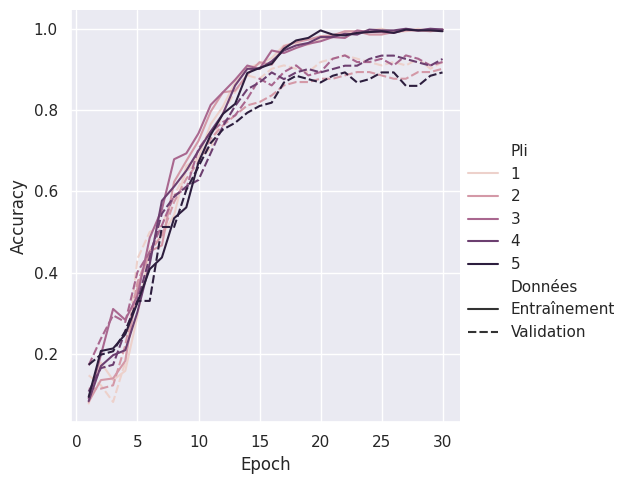

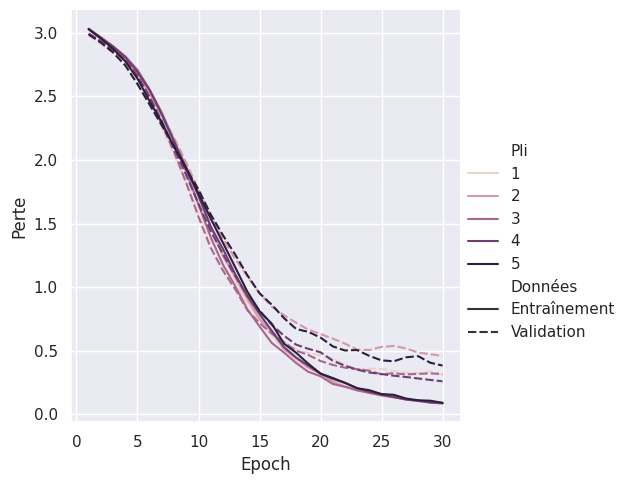

In [24]:
plot_results(biLSTM_histories)

🔎 Le modèle atteint une justesse de **91,12 % (± 1,22)**. Cependant, on observe sur les graphiques que la pente de la courbe de la justesse s'aplatit vers la 20ᵉ époque. La perte diminue jusqu'à la 25ᵉ époque, puis commence à s'aplatir, voire à augmenter de nouveau. Les performances du modèle sont satisfaisantes, mais l'entraînement devrait plutôt s'arrêter à la 25ᵉ époque pour éviter un sur-ajustement du modèle.

## Entraînement sur l'ensemble des données

Après avoir obtenu des résultats satisfaisants, nous ré-entraînons le modèle sur l'ensemble des données d'entraînement (colonne `description_wosw`, sans validation croisée), mais on restreint l'apprentissage à 25 époques. On teste le modèle sur les deux autres colonnes de notre jeu de données de **test**, toujours sans mots outils.

**Test sur la colonne <u>description</u> :**

In [25]:
X_test = test_df.description_wosw
y_test = test_df.label_fr.map(class_index)

In [26]:
def train_model(X_train, X_test, y_train, y_test, model_function, vectorizer,
                voc_size, embedding_matrix, embedding_dim=300, batch_size=128):

  m_function = globals()[model_function]
  model = m_function(voc_size, embedding_matrix, embedding_dim)

  print('------------------------------------------------------------------------')
  print('Entraînement du modèle ...')

  # Vectorisation
  x_train = vectorizer(X_train.to_numpy()).numpy()
  x_test = vectorizer(X_test.to_numpy()).numpy()

  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()

  # Compilation du modèle
  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
  )

  # Entraînement
  history = model.fit(x_train, y_train, batch_size=batch_size,
                      epochs=25, validation_data=(x_test, y_test))

  # Évaluation
  scores = model.evaluate(x_test, y_test, verbose=0)
  print(f'Scores: {model.metrics_names[0]} = {scores[0]:.2f}; {model.metrics_names[1]} = {scores[1]*100:.2f}%')

  print('---------------------------------------------------------------------')
  print('Score final sur les données de test :')
  print(f'> Accuracy: {scores[1]*100:.2f}%')
  print(f'> Loss: {scores[0]:.2f}')
  print('---------------------------------------------------------------------')

  return history

In [29]:
# Entraînement du modèle

biLSTM_histories = train_model(X_train, X_test, y_train, y_test, 'get_biLSTM_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix)

------------------------------------------------------------------------
Entraînement du modèle ...
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 662ms/step - loss: 3.0375 - sparse_categorical_accuracy: 0.0734 - val_loss: 2.9903 - val_sparse_categorical_accuracy: 0.0987
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 599ms/step - loss: 2.9604 - sparse_categorical_accuracy: 0.1224 - val_loss: 2.9347 - val_sparse_categorical_accuracy: 0.0395
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - loss: 2.8646 - sparse_categorical_accuracy: 0.0852 - val_loss: 2.8716 - val_sparse_categorical_accuracy: 0.0855
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 719ms/step - loss: 2.7689 - sparse_categorical_accuracy: 0.2090 - val_loss: 2.7521 - val_sparse_categorical_accuracy: 0.2697
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 792ms/step - loss: 2.6134 - sparse_categorical_accuracy: 0.4052 - val_loss: 2.5356 - val_sparse_categorical_accuracy: 0.4276
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - loss: 2.3617 - sparse_categ

**Test sur les descriptions <u>simples</u>** :

In [30]:
X_test = test_df.simple_wosw
biLSTM_histories_simple = train_model(X_train, X_test, y_train, y_test, 'get_biLSTM_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix)

------------------------------------------------------------------------
Entraînement du modèle ...
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - loss: 3.0250 - sparse_categorical_accuracy: 0.0785 - val_loss: 2.9863 - val_sparse_categorical_accuracy: 0.0855
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - loss: 2.9424 - sparse_categorical_accuracy: 0.1409 - val_loss: 2.9344 - val_sparse_categorical_accuracy: 0.0526
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - loss: 2.8684 - sparse_categorical_accuracy: 0.1271 - val_loss: 2.8791 - val_sparse_categorical_accuracy: 0.0987
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 2.7559 - sparse_categorical_accuracy: 0.2037 - val_loss: 2.7690 - val_sparse_categorical_accuracy: 0.2171
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 2.5661 - sparse_categorical_accuracy: 0.4159 - val_loss: 2.6049 - val_sparse_categorical_accuracy: 0.3947
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 2.3759 - sparse_catego

**Test sur les descriptions <u>avec fautes</u> :**

In [31]:
X_test = test_df.fautes_wosw
biLSTM_histories_fautes = train_model(X_train, X_test, y_train, y_test, 'get_biLSTM_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix)

------------------------------------------------------------------------
Entraînement du modèle ...
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step - loss: 3.0331 - sparse_categorical_accuracy: 0.0700 - val_loss: 3.0022 - val_sparse_categorical_accuracy: 0.1382
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - loss: 2.9582 - sparse_categorical_accuracy: 0.2327 - val_loss: 2.9538 - val_sparse_categorical_accuracy: 0.1382
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 2.8659 - sparse_categorical_accuracy: 0.3424 - val_loss: 2.8975 - val_sparse_categorical_accuracy: 0.1908
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 2.7367 - sparse_categorical_accuracy: 0.3810 - val_loss: 2.8193 - val_sparse_categorical_accuracy: 0.1974
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 2.5622 - sparse_categorical_accuracy: 0.3847 - val_loss: 2.6858 - val_sparse_categorical_accuracy: 0.3289
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 2.3547 - sparse_catego

## 🔎 Analyse des résultats

Le modèle obtient des résultats très comparables à ceux obtenus avec le CNN. La justesse est la même **(91,45%)** pour les deux modèles lorsque l'on teste sur la colonne "description" de notre jeu de données de test. La justesse pour la prédiction des descriptions simples est plus élevée avec BiLSTM. Cela pourrait être interprété par la fin de l'entraînement à la 25ᵉ époque, ce qui pourrait indiquer que le modèle CNN est plus ajusté aux données d'apprentissage et gère moins bien les descriptions plus simples.

In [33]:
results_biLSTM = pd.DataFrame({
    "biLSTM": [91.45],
    "biLSTM_simple": [85.53],
    "biLSTM_fautes": [73.03]
})

results_biLSTM

,biLSTM,biLSTM_simple,biLSTM_fautes
0,91.45,85.53,73.03


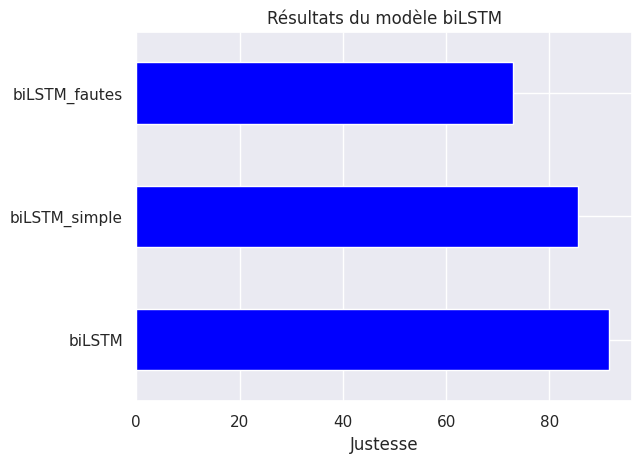

In [34]:
results_biLSTM.T.plot(kind="barh", color="blue", legend=False)
plt.xlabel("Justesse")
plt.title("Résultats du modèle biLSTM")
plt.show()

In [35]:
!mkdir results
results_biLSTM.to_csv("results/results_biLSTM.csv", index=False)